Credits to the Affine Mortality Package by Francesco Ungolo - https://github.com/ungolof/AffineMortality

# Package Installation

In [3]:
library(demography)
library(StMoMo)
library(lifecontingencies)
library(stats4)
library(sde)

# Data Retrieval

In [4]:
source("Mortality Scripts.R")
DNKdata <- hmd.mx(country = "DNK", username = username, password = password)

# Get the central exposure from Danish male subpopulation ages 50-99 from 1970 to 2014
DNKmales = DNKdata[["rate"]]$male[51:100, 145:180]

# Functions from  https://github.com/ungolof/AffineMortality

In [5]:
# Parameter estimates from the Danish dataset seen in Ungolo et al. (2021) https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3912981
# st_val = list(x0=c(1.611524e-03, 5.763081e-03, 1.208483e-02), delta=c(-0.12379389, -0.06208546, -0.08131285), kappa=c(1.6651e-16, 0.34776, 0.04620), sigma=c(4.143351e-03, 6.242207e-02, 1.797287e-02), theta_P = c(9.322613e-03, 8.457568e-03, 4.661882e-03), r1=2.952881e-15, r2=5.445661e-01, rc=1.493218e-07)

# Default starting values from the repository
st_val=list(x0=c(5.080033e-11, 1.535266e-02, 2.972783e-03, 5.091784e-03), delta=c(-0.2183696, 0.2865177, -0.1307629, -0.06), kappa=c(0.001292314, 0.485964737, 0.129874648, 0.001), sigma=c(0.002777236, 0.004947513, 0.021948997, 0.0136), theta_P=c(5.368400e-03, 7.074616e-03, 5.759856e-09, 0.00137), r1=2.776231e-22, r2=8.408350e-01, rc=1.668493e-07)

In [6]:
affine_fit <- function(model="BS", fact_dep=FALSE, n_factors=3, data=data_default, max_iter=200, tolerance=0.1){
    if(model=="CIR"){
        fit <- co_asc_CIR(mu_bar = data, x0=st_val$x0[1:n_factors], delta=st_val$delta[1:n_factors], kappa=st_val$kappa[1:n_factors], sigma = st_val$sigma[1:n_factors], theta_P = st_val$theta_P[1:n_factors], r=c(st_val$r1, st_val$r2, st_val$rc), max_iter=max_iter, tol_lik=1)
    return(list(model=model, fit=fit, n.parameters=(3 + n_factors*5), AIC=AIC_BIC(fit$log_lik, (3 + n_factors*5), (nrow(data) * ncol(data)))$AIC, BIC=AIC_BIC(fit$log_lik, (3 + n_factors*5), (nrow(data) * ncol(data)))$BIC))
    }
}

In [7]:
co_asc_CIR <- function(mu_bar = DNKmales, x0, delta, kappa, sigma, theta_P, r=c(2.952881e-15, 5.445661e-01, 1.493218e-07), max_iter=200, tol_lik=1){
  
  n_factors <- length(kappa)
  # - Matrix for parameter estimates storage
  CA_par <- matrix(NA, nrow=max_iter, ncol=length(c(x0, delta, kappa, sigma, theta_P, r))+1)
  colnames(CA_par) <- c(sprintf("x0_%d", c(1:n_factors)), sprintf("delta_%d", c(1:n_factors)), sprintf("kappa_%d", c(1:n_factors)), sprintf("sigma_%d", c(1:n_factors)), sprintf("theta_P_%d", c(1:n_factors)), c("r1", "r2", "rc"), "log_lik")
  # - Initialize log-likelihood
  neg_loglikelihood <- 0
  
  ## - Factor covariance matrix at t=0
  
  l_x0_par <- log(x0)
  delta_par <- delta
  l_kappa_par <- log(kappa) # - take logs to ensure positivity
  l_sigma_par <- log(sigma)
  l_theta_P_par <- log(theta_P)
  l_r_par <- log(r)
  
  iter_count <- 1
  repeat{
    
    l_x0_opt_CIR_KD <- optim(l_x0_par, nLL_CIR_uKD_CA_bd, mu_bar=mu_bar, delta=delta_par, l_kappa=l_kappa_par, l_sigma=l_sigma_par, l_theta_P=l_theta_P_par, l_r=l_r_par, gr = NULL, method = "Nelder-Mead", hessian = FALSE, control=list(maxit = 10000))  
    l_x0_par <- l_x0_opt_CIR_KD$par
    print(paste(sprintf("X(0)_%d", c(1:n_factors)), round(exp(l_x0_par),3)))
    
    delta_opt_CIR_KD <- optim(delta_par, nLL_CIR_uKD_CA_bd, mu_bar=mu_bar, l_x0=l_x0_par, l_kappa=l_kappa_par, l_sigma=l_sigma_par, l_theta_P=l_theta_P_par, l_r=l_r_par, gr = NULL, method = "Nelder-Mead", hessian = FALSE, control=list(maxit = 10000))  
    delta_par <- delta_opt_CIR_KD$par
    print(paste(sprintf("delta_%d", c(1:n_factors)), round(delta_par,3)))
    
    l_kappa_opt_CIR_KD <- optim(l_kappa_par, nLL_CIR_uKD_CA_bd, mu_bar=mu_bar, delta=delta_par, l_x0=l_x0_par, l_sigma=l_sigma_par, l_theta_P=l_theta_P_par, l_r=l_r_par, gr = NULL, method = "Nelder-Mead", hessian = FALSE, control=list(maxit = 10000))  
    l_kappa_par <- l_kappa_opt_CIR_KD$par
    print(paste(sprintf("kappa_%d", c(1:n_factors)), round(exp(l_kappa_par),3)))
    
    l_sigma_opt_CIR_KD <- optim(l_sigma_par, nLL_CIR_uKD_CA_bd, mu_bar=mu_bar, delta=delta_par, l_kappa=l_kappa_par, l_x0=l_x0_par, l_theta_P=l_theta_P_par, l_r=l_r_par, gr = NULL, method = "Nelder-Mead", hessian = FALSE, control=list(maxit = 10000))  
    l_sigma_par <- l_sigma_opt_CIR_KD$par
    print(paste(sprintf("sigma_%d", c(1:n_factors)), round(exp(l_sigma_par),3)))
    
    l_theta_P_opt_CIR_KD <- optim(l_theta_P_par, nLL_CIR_uKD_CA_bd, mu_bar=mu_bar, delta=delta_par, l_kappa=l_kappa_par, l_sigma=l_sigma_par, l_x0=l_x0_par, l_r=l_r_par, gr = NULL, method = "Nelder-Mead", hessian = FALSE, control=list(maxit = 10000))  
    l_theta_P_par <- l_theta_P_opt_CIR_KD$par
    print(paste(sprintf("theta_P_%d", c(1:n_factors)), round(exp(l_theta_P_par), 3)))
    
    l_r_opt_CIR_KD <- optim(l_r_par, nLL_CIR_uKD_CA_bd, mu_bar=mu_bar, delta=delta_par, l_kappa=l_kappa_par, l_sigma=l_sigma_par, l_theta_P=l_theta_P_par, l_x0=l_x0_par, gr = NULL, method = "Nelder-Mead", hessian = FALSE, control=list(maxit = 10000))  
    l_r_par <- l_r_opt_CIR_KD$par
    print(paste(c("r1", "r2", "rc"), round(exp(l_r_par),3)))
    
    # - Store par_est
    CA_par[iter_count, 1:length(c(x0, delta, kappa, sigma, theta_P, r))] <- c(exp(l_x0_par), delta_par, exp(l_kappa_par), exp(l_sigma_par), exp(l_theta_P_par), exp(l_r_par))
    CA_par[iter_count, length(c(x0, delta, kappa, sigma, theta_P, r))+1] <- -0.5 * nLL_CIR_uKD_CA_bd(l_x0_par, delta_par, l_kappa_par, l_sigma_par, l_theta_P_par, l_r_par, mu_bar) - 0.5 * nrow(mu_bar) * ncol(mu_bar)
    
    if (abs(nLL_CIR_uKD_CA_bd(l_x0_par, delta_par, l_kappa_par, l_sigma_par, l_theta_P_par, l_r_par, mu_bar) - neg_loglikelihood) < tol_lik | (iter_count==max_iter) ){
      break
    }else{
      # - Update log-likelihood
      neg_loglikelihood <- nLL_CIR_uKD_CA_bd(l_x0_par, delta_par, l_kappa_par, l_sigma_par, l_theta_P_par, l_r_par, mu_bar)
      
      print(paste("log_lik", round(CA_par[iter_count, length(c(x0, delta, kappa, sigma, theta_P, r))+1],2)))
      print(paste(iter_count, "% iteration"))
      print(paste("---------------------------------"))
      
      iter_count <- iter_count + 1
    }
  }
  
  return(list(par_est = list(x0=CA_par[iter_count,1:n_factors], delta=CA_par[iter_count,((n_factors + 1):(n_factors*2))], kappa=CA_par[iter_count,((n_factors*2 + 1):(n_factors*3))], sigma=CA_par[iter_count,((n_factors*3 + 1):(n_factors*4))], theta_P=CA_par[iter_count,((n_factors*4 + 1):(n_factors*5))], r1=CA_par[iter_count,(n_factors*5 + 1)], r2=CA_par[iter_count,(n_factors*5 + 2)], rc=CA_par[iter_count,(n_factors*5 + 3)]), log_lik = CA_par[iter_count,length(c(x0, delta, kappa, sigma, theta_P, r))+1], CA_table = CA_par[1:iter_count,]))
}

In [8]:
nLL_CIR_uKD_CA_bd <- function(l_x0, delta, l_kappa, l_sigma, l_theta_P, l_r, mu_bar = DNKmales){
  
  r_1 <- l_r[1]
  r_2 <- l_r[2]
  r_c <- l_r[3]
  
  n_factors <- length(l_kappa)
  
  n_ages <- nrow(DNKmales)   # - Number of ages
  n_years <- ncol(DNKmales)  # - Number of years
  
  v_ti <- matrix(0, n_ages, n_years)
  F_ti <- matrix(1, n_ages, n_years)
  
  ## - Factor loading matrices
  A_tT <- matrix(0, n_ages, 1)
  B_tT <- matrix(NA, n_ages, n_factors)
  R <- matrix(0, n_factors, n_factors * (n_years + 1)) # - Factor covariance
  
  # - Initialize X and Sigma
  x_ti <- exp(l_x0)
  P_ti <- 1e-10 * diag(1, n_factors)
  
  for(age in 1:n_ages){    # - scroll over the ages
    A_tT[age,1] <- A_CIR(age, (exp(l_theta_P + l_kappa) / delta), exp(l_sigma), delta)  
    B_tT[age,] <- B_CIR(age, exp(l_sigma), delta)  
  }
  
  Phi <- diag(exp(-exp(l_kappa)), n_factors) # K_p <- diag(kappa, 2) ## exp(-K_p)
  
  for(t in 1:n_years){
    
    R[,(t * n_factors + 1):((t+1) * n_factors)] <- diag(exp(2 * l_sigma) * ((1 - exp(-exp(l_kappa))) / exp(l_kappa)) * (0.5 * exp(l_theta_P) * (1 - exp(-exp(l_kappa))) + exp(-exp(l_kappa)) * x_ti[1:n_factors]),n_factors)
    
    # - First observation
    x_ti <- Phi %*% x_ti + exp(l_theta_P) * (1 - exp(-exp(l_kappa)))
    x_ti <- l_bound(x_ti)
    P_ti <- Phi %*% P_ti %*% t(Phi) + R[,(t * n_factors + 1):((t+1) * n_factors)]     # - P_{1,t}
    v_ti[1,t] <- DNKmales[1,t] - A_tT[1] - B_tT[1,] %*% x_ti
    F_ti[1,t] <- B_tT[1,] %*% P_ti %*% B_tT[1,] + exp(r_c) + exp(r_1 + exp(r_2))    
    
    for(i in 2:n_ages){
      x_ti <- x_ti + P_ti %*% B_tT[i-1,] %*% (1 / F_ti[i-1,t]) %*% v_ti[i-1,t]
      x_ti <- l_bound(x_ti)
      
      # - Joseph formula univariate
      K_ti <- P_ti %*% B_tT[i-1,] / F_ti[i-1,t]
      P_ti <- (diag(1, n_factors) - K_ti %*% B_tT[i-1,]) %*% P_ti %*% t(diag(1, n_factors) - K_ti %*% B_tT[i-1,]) + K_ti %*% (exp(r_c) + exp(r_1) * sum(exp(exp(r_2) * c(1:(i-1)))) / (i-1)) %*% t(K_ti) 
      
      # - log-likelihood values from Koopman and Durbin
      F_ti[i,t] <- B_tT[i,] %*% P_ti %*% B_tT[i,] + exp(r_c) + exp(r_1) * sum(exp(exp(r_2) * c(1:i))) / i 
      v_ti[i,t] <- DNKmales[i,t] - A_tT[i] - B_tT[i,] %*% x_ti
      
    }
  }
  
  log_lik <- sum(log(F_ti) + (v_ti^2) / F_ti)
  return(log_lik)
}

In [9]:
# - CIR model
### - Same A_CIR as before, but using ^0.5 instead of sqrt() for computational reasons
A_CIR <- function(T, theta_Q, sigma, delta){
  value <- - 2 * sum((delta * theta_Q / (sigma^2)) * (log(2) + 0.5 * log((delta ^ 2) + 2 * (sigma ^ 2)) + 0.5 * T * (delta + ((delta ^ 2) + 2 * (sigma ^ 2))^0.5) - log( (delta + ((delta ^ 2) + 2 * (sigma ^ 2))^0.5) * (exp(T * ((delta ^ 2) + 2 * (sigma ^ 2))^0.5) - 1) + 2 * ((delta ^ 2) + 2 * (sigma ^ 2))^0.5  ))) / T
  return(value)
}

### - Same B_CIR as before, but using ^0.5 instead of sqrt() for computational reasons
B_CIR <- function(T, sigma, delta){
  B <- 2 * (exp(T * ((delta ^ 2) + 2 * (sigma ^ 2))^0.5) - 1) / ((delta + ((delta ^ 2) + 2 * (sigma ^ 2))^0.5) * (exp(T * ((delta ^ 2) + 2 * (sigma ^ 2))^0.5) - 1) + 2 * ((delta ^ 2) + 2 * (sigma ^ 2))^0.5) / T
  return(B)
}

l_bound <- function(X){
  Xb <- X
  for(j in 1:length(X)){
    Xb[j] <- max(1e-10, X[j])
  }
  return(Xb)
}

In [10]:
#==========================================================
# - Model Selection (AIC and BIC) - Build cross-validation
#==========================================================

AIC_BIC <- function(log_likelihood, n_par, n_obs){
  
  AIC <- - 2 * log_likelihood + 2 * n_par
  BIC <- - 2 * log_likelihood + n_par * log(n_obs)
  
  return(list(AIC=AIC, BIC=BIC))
}

#==================================================
# - Root Mean Squared Error (RMSE)
#==================================================

# - First reproduce mu_bar_hat for all models

RMSE <- function(observed, estimated){
  RMSE <- sqrt(mean((observed - estimated)^2))
  return(RMSE)  
}


#=======================================================
# - Mean Absolute Percentage Error (MAPE)
#=======================================================

MAPE_row <- function(observed, estimated){
  MAPE <- rowMeans(abs((observed - estimated)/observed))
  return(MAPE)  
}


#=======================================================
# - Fitted rates (useful for residuals plot and RMSE)
#=======================================================

# - mu_bar hat

# - Residuals
residuals_f <- function(observed, estimated){
  residuals <- observed - estimated
  colnames(residuals) <- colnames(observed)
  rownames(residuals) <- rownames(observed)
  return(residuals)
}

## - 0/1 residuals (0 if negative, 1 if positive)
residuals_01 <- function(observed, estimated){
  residuals <- ifelse(observed - estimated > 0, 1, 0)
  colnames(residuals) <- colnames(observed)
  rownames(residuals) <- rownames(observed)
  return(residuals)
}

residuals_std_CIR <- function(observed, x0, delta, kappa, sigma, theta_P, r){
  n_factors <- length(kappa)
  n_ages <- nrow(observed)
  n_years <- ncol(observed)
  
  B_tT <- matrix(NA, n_ages, n_factors)
  
  l_r1 <- log(r[1])
  l_r2 <- log(r[2])
  l_rc <- log(r[3])
  
  B_tT <- matrix(NA, n_ages, n_factors)
  R <- matrix(0, n_factors, n_factors) # - Factor covariance
  
  for(age in 1:n_ages){    # - scroll over the ages
    B_tT[age,] <- B_CIR(age, sigma, delta)  
  }
  
  residuals <- observed - mu_bar_hat_CIR(x0, delta, kappa, sigma, theta_P, r, observed)
  H <- meas_err_BS(l_r1, l_r2, l_rc, observed)
  
  X_t <- KF_CIR_uKD(x0, delta, kappa, sigma, theta_P, r, observed)$X_t
  P_ti <- 1e-10 * diag(1, n_factors)
  
  Var_y <- matrix(0, n_years, n_years)
  
  
  for(t in 1:n_years){
    R <- diag((sigma^2) * ((1 - exp(-kappa)) / kappa) * (0.5 * theta_P * (1 - exp(-kappa)) + exp(-kappa) * X_t[,t+1]), n_factors)
    Var_y <- H + (B_tT %*% R %*% t(B_tT)) 
    premultiplier <- solve(sqrtm(Var_y))
    
    residuals[,t] <- premultiplier %*% residuals[,t]
  }
  
  colnames(residuals) <- colnames(observed)
  rownames(residuals) <- rownames(observed)
  return(residuals)
}

# Fitting the model to data

In [11]:
# source("AffineMortality.R")
param_est = affine_fit(
  model = "CIR",
  fact_dep = FALSE,
  n_factors = 3,
  data = DNKmales,
  max_iter = 200,
  tolerance = 1
)

[1] "X(0)_1 0"     "X(0)_2 0.005" "X(0)_3 0.007"
[1] "delta_1 -0.191" "delta_2 14.129" "delta_3 -0.152"
[1] "kappa_1 0.002" "kappa_2 0.062" "kappa_3 0.1"  
[1] "sigma_1 0.003" "sigma_2 0.02"  "sigma_3 0.021"
[1] "theta_P_1 0.007" "theta_P_2 0.047" "theta_P_3 0"    
[1] "r1 0"     "r2 0.342" "rc 0"    
[1] "log_lik 7973.99"
[1] "1 % iteration"
[1] "---------------------------------"
[1] "X(0)_1 0.001" "X(0)_2 0"     "X(0)_3 0.006"
[1] "delta_1 -0.19"  "delta_2 14.129" "delta_3 -0.148"
[1] "kappa_1 0.002" "kappa_2 0.015" "kappa_3 0.089"
[1] "sigma_1 0.003" "sigma_2 0.02"  "sigma_3 0.022"
[1] "theta_P_1 0.006" "theta_P_2 0.048" "theta_P_3 0"    
[1] "r1 0"     "r2 0.341" "rc 0"    
[1] "log_lik 8336.61"
[1] "2 % iteration"
[1] "---------------------------------"
[1] "X(0)_1 0.001" "X(0)_2 0"     "X(0)_3 0.006"
[1] "delta_1 -0.19"  "delta_2 14.129" "delta_3 -0.147"
[1] "kappa_1 0.002" "kappa_2 0.011" "kappa_3 0.092"
[1] "sigma_1 0.003" "sigma_2 0.02"  "sigma_3 0.021"
[1] "theta_P_1 0.005" 

In [12]:
# The parameter estimates are given by
param_est$fit

x0_1,x0_2,x0_3,delta_1,delta_2,delta_3,kappa_1,kappa_2,kappa_3,sigma_1,sigma_2,sigma_3,theta_P_1,theta_P_2,theta_P_3,r1,r2,rc,log_lik
1.407410e-09,5.105222e-03,0.006742299,-0.1910613,14.1288,-0.1524817,0.0023249125,0.062247499,0.10015147,0.002763811,0.02009483,0.02119096,0.006677156,0.04733357,6.916395e-09,3.657488e-09,0.3419711,9.860640e-07,7973.991
5.476764e-04,1.491187e-07,0.006089897,-0.1904514,14.1288,-0.1480342,0.0020537957,0.014666125,0.08923385,0.002781034,0.02009478,0.02151445,0.006006284,0.04759387,1.609441e-08,2.450364e-09,0.3407081,9.681202e-07,8336.610
6.007821e-04,2.305986e-07,0.006377253,-0.1902891,14.1288,-0.1469120,0.0015178990,0.010638273,0.09208785,0.002703468,0.02009484,0.02091576,0.005349500,0.06035684,2.814411e-08,2.172811e-09,0.3435056,9.929500e-07,8341.264
6.098974e-04,2.582216e-07,0.006463104,-0.1897247,14.1288,-0.1461251,0.0012824107,0.007779433,0.08862393,0.002671325,0.02009479,0.02058642,0.005556593,0.07189040,3.084971e-08,2.059404e-09,0.3447722,1.005073e-06,8343.301
6.154666e-04,4.430307e-07,0.006507460,-0.1892406,14.1288,-0.1456037,0.0011224400,0.006256957,0.08625392,0.002656586,0.02009486,0.02037719,0.006158749,0.08247611,7.396481e-08,1.995072e-09,0.3455309,1.011841e-06,8344.266
6.206653e-04,3.523232e-07,0.006525400,-0.1888066,14.1288,-0.1452507,0.0010176307,0.005297425,0.08509923,0.002646691,0.02009118,0.02022242,0.006460851,0.09847249,3.810242e-05,1.942180e-09,0.3461446,1.019179e-06,8344.819
6.239453e-04,5.331918e-07,0.006515148,-0.1882998,14.1288,-0.1448381,0.0009998167,0.004548285,0.09008842,0.002656524,0.02009475,0.02018903,0.007877679,0.11851613,9.146299e-05,1.930079e-09,0.3463187,1.018920e-06,8345.438
6.224194e-04,5.335503e-07,0.006522347,-0.1878977,14.1288,-0.1444480,0.0009580101,0.003981626,0.09795785,0.002657576,0.02009482,0.02013361,0.008722544,0.13769498,1.322903e-04,1.924210e-09,0.3463752,1.020327e-06,8345.922


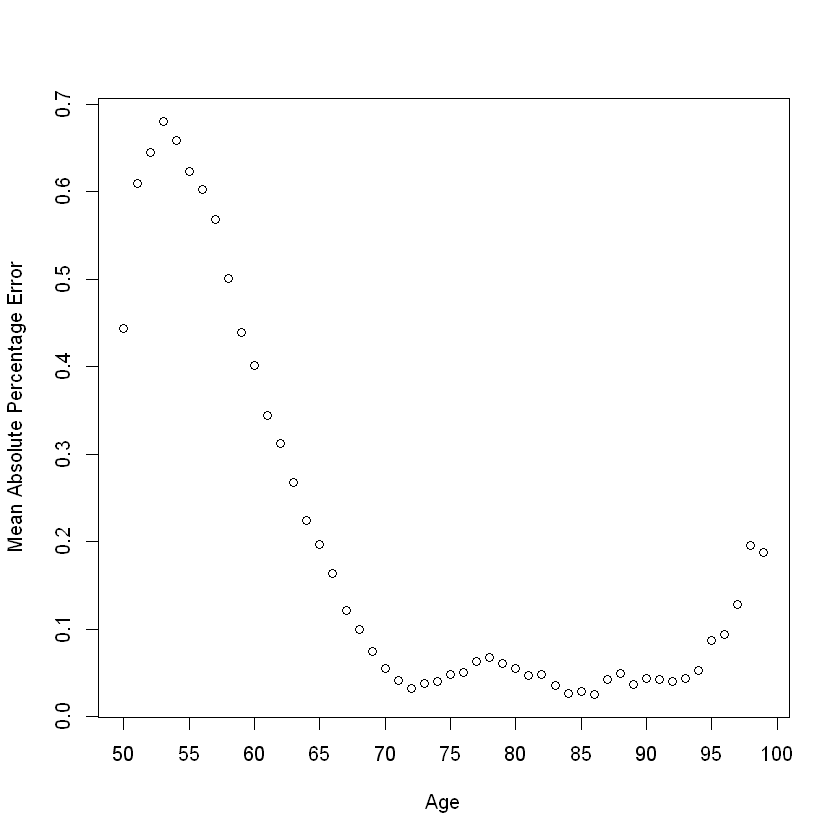

In [24]:
# Calculate the Mean Absolute Percentage Error (MAPE)
source("AffineMortality.R")
estimated_mortality = mubar_hat(
  model = "CIR",
  fact_dep = FALSE,
  n_factors = 3,
  parameters = 0,
  data = DNKmales
)

MAPE = MAPE_row(DNKmales, estimated_mortality)
plot(seq(50,99,1), MAPE, xlab = "Age", ylab = "Mean Absolute Percentage Error")
axis(side = 1, at = seq(50,99,5))
box()